# Practice Lab: Advice for Applying Machine Learning
In this lab, you will explore techniques to evaluate and improve your machine learning models.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Evaluating a Learning Algorithm (Polynomial Regression)](#2)
  - [ 2.1 Splitting your data set](#2.1)
  - [ 2.2 Error calculation for model evaluation, linear regression](#2.2)
    - [ Exercise 1](#ex01)
  - [ 2.3 Compare performance on training and test data](#2.3)
- [ 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> ](#3)
  - [ 3.1 Plot Train, Cross-Validation, Test](#3.1)
  - [ 3.2 Finding the optimal degree](#3.2)
  - [ 3.3 Tuning Regularization.](#3.3)
  - [ 3.4 Getting more data: Increasing Training Set Size (m)](#3.4)
- [ 4 - Evaluating a Learning Algorithm (Neural Network)](#4)
  - [ 4.1 Data Set](#4.1)
  - [ 4.2 Evaluating categorical model by calculating classification error](#4.2)
    - [ Exercise 2](#ex02)
- [ 5 - Model Complexity](#5)
  - [ Exercise 3](#ex03)
  - [ 5.1 Simple model](#5.1)
    - [ Exercise 4](#ex04)
- [ 6 - Regularization](#6)
  - [ Exercise 5](#ex05)
- [ 7 - Iterate to find optimal regularization value](#7)
  - [ 7.1 Test](#7.1)


<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [scikitlearn](https://scikit-learn.org/stable/) is a basic library for data mining
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-11-21 17:09:16.710923: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-21 17:09:16.779519: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 17:09:16.779631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 17:09:16.782890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alre

<a name="2"></a>
## 2 - Evaluating a Learning Algorithm (Polynomial Regression)

<img align="Right" src="./images/C2_W3_TrainingVsNew.png"  style=" width:350px; padding: 10px 20px ; "> Let's say you have created a machine learning model and you find it *fits* your training data very well. You're done? Not quite. The goal of creating the model was to be able to predict values for <span style="color:blue">*new* </span> examples. 

How can you test your model's performance on new data before deploying it?   
The answer has two parts:
* Split your original data set into "Training" and "Test" sets. 
    * Use the training data to fit the parameters of the model
    * Use the test data to evaluate the model on *new* data
* Develop an error function to evaluate your model.

<a name="2.1"></a>
### 2.1 Splitting your data set
Lectures advised reserving 20-40% of your data set for testing. Let's use an `sklearn` function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform the split. Double-check the shapes after running the following cell.

In [2]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


#### 2.1.1 Plot Train, Test sets
You can see below the data points that will be part of training (in red) are intermixed with those that the model is not trained on (test). This particular data set is a quadratic function with noise added. The "ideal" curve is shown for reference.

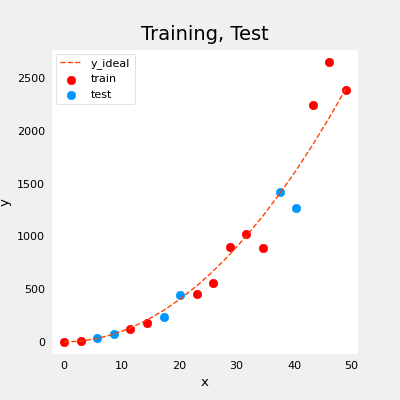

In [3]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="2.2"></a>
### 2.2 Error calculation for model evaluation, linear regression
When *evaluating* a linear regression model, you average the squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

<a name="ex01"></a>
### Exercise 1

Below, create a function to evaluate the error on a data set for a linear regression model.

In [4]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ### 
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)
    ### END CODE HERE ### 
    
    return(err)

In [5]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

    
```python
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)                    
    return(err)
``` 

<a name="2.3"></a>
### 2.3 Compare performance on training and test data
Let's build a high degree polynomial model to minimize training error. This will use the linear_regression functions from `sklearn`. The code is in the imported utility file if you would like to see the details. The steps below are:
* create and fit the model. ('fit' is another name for training or running gradient descent).
* compute the error on the training data.
* compute the error on the test data.

In [6]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

The computed error on the training set is substantially less than that of the test set. 

In [7]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


The following plot shows why this is. The model fits the training data very well. To do so, it has created a complex function. The test data was not part of the training and the model does a poor job of predicting on this data.  
This model would be described as 1) is overfitting, 2) has high variance 3) 'generalizes' poorly.

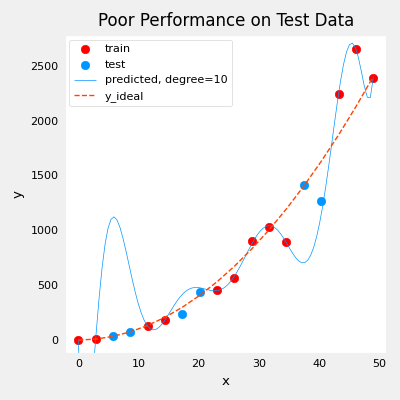

In [8]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent *new* data.
You need yet another set of data to test new data performance.

The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits:

In [9]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


<a name="3"></a>
## 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> 
 Above, it was clear the degree of the polynomial model was too high. How can you choose a good value? It turns out, as shown in the diagram, the training and cross-validation performance can provide guidance. By trying a range of degree values, the training and cross-validation performance can be evaluated. As the degree becomes too large, the cross-validation performance will start to degrade relative to the training performance. Let's try this on our example.

<a name="3.1"></a>
### 3.1 Plot Train, Cross-Validation, Test
You can see below the datapoints that will be part of training (in red) are intermixed with those that the model is not trained on (test and cv).

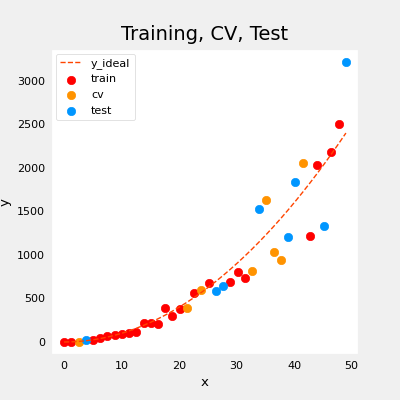

In [10]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="3.2"></a>
### 3.2 Finding the optimal degree
In previous labs, you found that you could create a model capable of fitting complex curves by utilizing a polynomial (See Course1, Week2 Feature Engineering and Polynomial Regression Lab).  Further, you demonstrated that by increasing the *degree* of the polynomial, you could *create* overfitting. (See Course 1, Week3, Over-Fitting Lab). Let's use that knowledge here to test our ability to tell the difference between over-fitting and under-fitting.

Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) linear regression model for speed and simplicity.

In [11]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

<font size="4">Let's plot the result:</font>

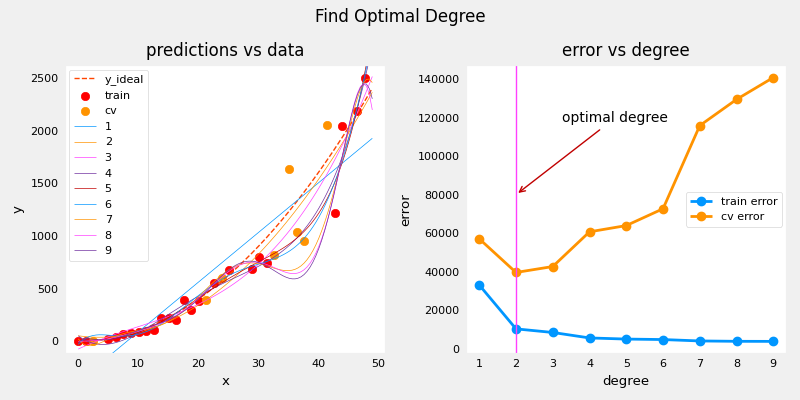

In [12]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used. 
- On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point. 
- on the right:
    - the error on the trained data (blue) decreases as the model complexity increases as expected
    - the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to *generalize*).     
    
It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

<a name="3.3"></a>
### 3.3 Tuning Regularization.
In previous labs, you have utilized *regularization* to reduce overfitting. Similar to degree, one can use the same methodology to tune the regularization parameter lambda ($\lambda$).

Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter.

In [13]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

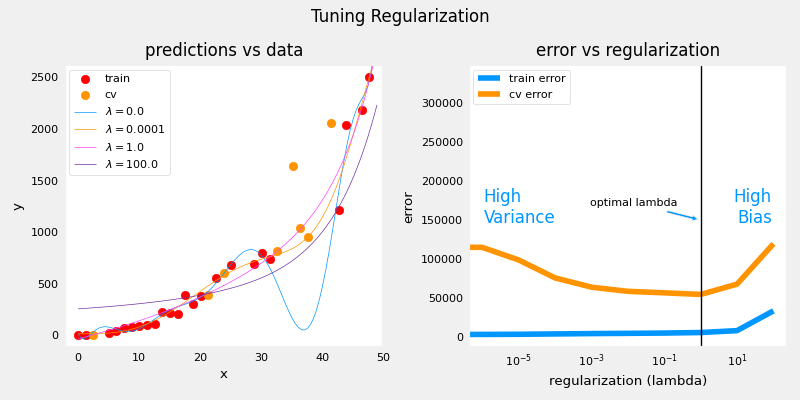

In [14]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

<a name="3.4"></a>
### 3.4 Getting more data: Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

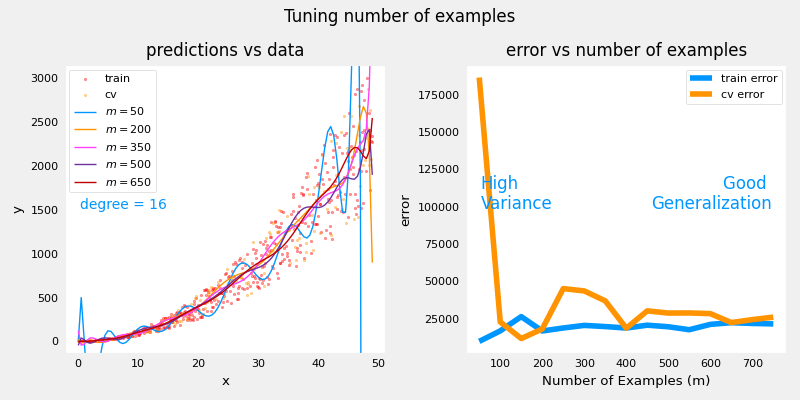

In [15]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization. 

> Note that adding more examples when the model has high bias (underfitting) does not improve performance.


<a name="4"></a>
## 4 - Evaluating a Learning Algorithm (Neural Network)
Above, you tuned aspects of a polynomial regression model. Here, you will work with a neural network model. Let's start by creating a classification data set. 

<a name="4.1"></a>
### 4.1 Data Set
Run the cell below to generate a data set and split it into training, cross-validation (CV) and test sets. In this example, we're increasing the percentage of cross-validation data points for emphasis.  

In [16]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


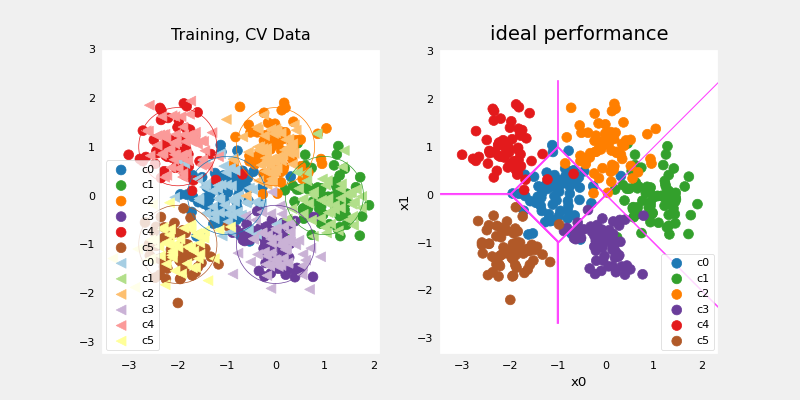

In [17]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

<a name="4.2"></a>
### 4.2 Evaluating categorical model by calculating classification error
The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>
### Exercise 2

Below, complete the routine to calculate classification error. Note, in this lab, target values are the index of the category and are not [one-hot encoded](https://en.wikipedia.org/wiki/One-hot).

In [18]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    ### START CODE HERE ### 
        if yhat[i] != y[i]:    
            incorrect += 1     
    cerr = incorrect/m         
    ### END CODE HERE ### 
    
    return(cerr)

In [19]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST
# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr)                                    
``` 

<a name="5"></a>
## 5 - Model Complexity
Below, you will build two models. A complex model and a simple model. You will evaluate the models to determine if they are likely to overfit or underfit.

###  5.1 Complex model

<a name="ex03"></a>
### Exercise 3
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)  
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [21]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ### 
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
        ### END CODE HERE ### 

    ], name="Complex"
)
model.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    
)

model.fit(
    X_train,y_train,
    epochs=1000
    ### END CODE HERE ### 
)

Epoch 1/1000
13/13 [==============================] - 1s 3ms/step - loss: 1.0384
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4043
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3123
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2778
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2763
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2863
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2408
Epoch 8/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2229
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2237
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2028
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2104
Epoch 12/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2054
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 2ms/step - loss: 0.1665
Epoch 102/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1597
Epoch 103/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1835
Epoch 104/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1605
Epoch 105/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1458
Epoch 106/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1430
Epoch 107/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1614
Epoch 108/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1439
Epoch 109/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1502
Epoch 110/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1473
Epoch 111/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1516
Epoch 112/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1633
Epoch 113/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1165
Epoch 200/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1098
Epoch 201/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0935
Epoch 202/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0885
Epoch 203/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0858
Epoch 204/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1075
Epoch 205/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1038
Epoch 206/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1180
Epoch 207/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1592
Epoch 208/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1558
Epoch 209/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1149
Epoch 210/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1119
Epoch 211/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0936
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0709
Epoch 299/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0651
Epoch 300/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0862
Epoch 301/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0902
Epoch 302/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0804
Epoch 303/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0998
Epoch 304/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0777
Epoch 305/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0862
Epoch 306/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0783
Epoch 307/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0959
Epoch 308/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0904
Epoch 309/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0502
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0523
Epoch 397/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0545
Epoch 398/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0596
Epoch 399/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0647
Epoch 400/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0671
Epoch 401/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0939
Epoch 402/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1002
Epoch 403/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0985
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1121
Epoch 405/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0958
Epoch 406/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0959
Epoch 407/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0468
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 495/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0402
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0361
Epoch 497/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0447
Epoch 498/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0460
Epoch 499/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0391
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 501/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0398
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0464
Epoch 503/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0453
Epoch 504/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0634
Epoch 505/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0439
Epoch 592/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0479
Epoch 593/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0393
Epoch 594/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0330
Epoch 595/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0296
Epoch 596/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 597/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0323
Epoch 598/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0303
Epoch 599/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0306
Epoch 600/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 601/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0339
Epoch 602/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 603/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1253
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1729
Epoch 691/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0780
Epoch 692/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0640
Epoch 693/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0624
Epoch 694/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0475
Epoch 695/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0431
Epoch 696/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0341
Epoch 697/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0368
Epoch 698/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 699/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0513
Epoch 700/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0395
Epoch 701/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0840
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0744
Epoch 789/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0370
Epoch 790/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0331
Epoch 791/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 792/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0303
Epoch 793/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0294
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0299
Epoch 795/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0250
Epoch 796/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0302
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0268
Epoch 798/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0262
Epoch 799/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 887/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 888/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 889/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 890/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0297
Epoch 891/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0234
Epoch 892/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0273
Epoch 893/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0632
Epoch 894/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0706
Epoch 895/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0832
Epoch 896/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1619
Epoch 897/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 985/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 986/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 987/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 988/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 989/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 990/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0215
Epoch 991/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0306
Epoch 992/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 993/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 994/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 995/1000
13/1

In [22]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0275
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0328
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0266
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0264
Epoch 8/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0331
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0321
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0239
Epoch 12/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 2ms/step - loss: 0.0657
Epoch 102/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1208
Epoch 103/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2333
Epoch 104/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1770
Epoch 105/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1753
Epoch 106/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1084
Epoch 107/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0513
Epoch 108/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0477
Epoch 109/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0331
Epoch 110/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0268
Epoch 111/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0463
Epoch 112/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0263
Epoch 113/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 200/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0255
Epoch 201/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0312
Epoch 202/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0352
Epoch 203/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0350
Epoch 204/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0270
Epoch 205/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0333
Epoch 206/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 207/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0309
Epoch 208/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0272
Epoch 209/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 210/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0220
Epoch 211/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0220
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 299/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 300/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 301/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 302/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 303/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 304/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 305/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 306/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 307/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 308/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0324
Epoch 309/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 397/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0305
Epoch 398/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0307
Epoch 399/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0257
Epoch 400/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0235
Epoch 401/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0260
Epoch 402/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0266
Epoch 403/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0255
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 405/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 406/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 407/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 495/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 497/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 498/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 499/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 501/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 503/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 504/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 505/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0531
Epoch 592/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0679
Epoch 593/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0239
Epoch 594/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0288
Epoch 595/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0269
Epoch 596/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 597/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 598/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 599/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 600/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0247
Epoch 601/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 602/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 603/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 691/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 692/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 693/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 694/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 695/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 696/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 697/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 698/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 699/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 700/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 701/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 789/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 790/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 791/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 792/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 793/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 795/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 796/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 798/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 799/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 887/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 888/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 889/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 890/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 891/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 892/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 893/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 894/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 895/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 896/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 897/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 985/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 986/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 987/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 988/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 989/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 990/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 991/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 992/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 993/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 994/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 995/1000
13/1

In [23]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 120)               360       
                                                                 
 L2 (Dense)                  (None, 40)                4840      
                                                                 
 L3 (Dense)                  (None, 6)                 246       
                                                                 
Total params: 5446 (42.55 KB)
Trainable params: 5446 (42.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)                                  
``` 

1082/1082 [==============================] - 1s 1ms/step


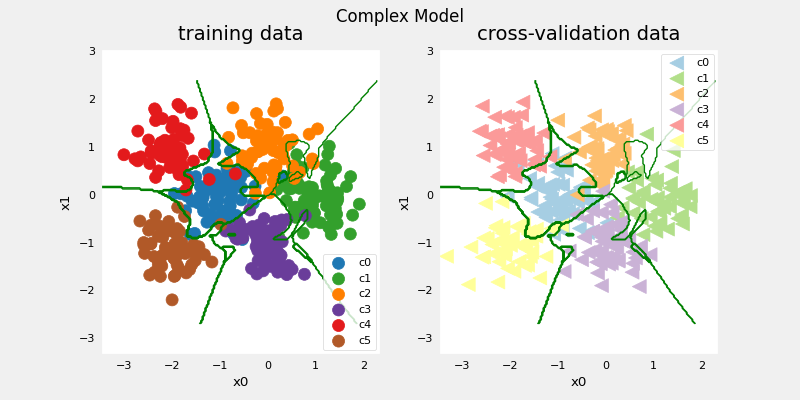

In [24]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [25]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 1ms/step
categorization error, training, complex model: 0.013
categorization error, cv,       complex model: 0.106


<a name="5.1"></a>
### 5.1 Simple model
Now, let's try a simple model

<a name="ex04"></a>
### Exercise 4

Below, compose a two-layer model:
* Dense layer with 6 units, relu activation
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [28]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ### 
        Dense(6, activation='relu', name="L1"),
        Dense(classes, activation='linear', name="L2")  
        ### END CODE HERE ### 
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### START CODE HERE ### 
)


In [29]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.9273
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.5724
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.3719
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.1908
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.0189
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8573
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7277
Epoch 8/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6179
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5390
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4794
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4363
Epoch 12/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4029
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 2ms/step - loss: 0.1946
Epoch 102/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1945
Epoch 103/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1954
Epoch 104/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1910
Epoch 105/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1907
Epoch 106/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1910
Epoch 107/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1897
Epoch 108/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1904
Epoch 109/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1919
Epoch 110/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1926
Epoch 111/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1898
Epoch 112/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1928
Epoch 113/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1899
Epoch 200/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1875
Epoch 201/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1877
Epoch 202/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1850
Epoch 203/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1869
Epoch 204/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1877
Epoch 205/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1860
Epoch 206/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1891
Epoch 207/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1861
Epoch 208/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1902
Epoch 209/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1859
Epoch 210/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1875
Epoch 211/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1908
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1898
Epoch 299/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1846
Epoch 300/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1883
Epoch 301/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1848
Epoch 302/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1904
Epoch 303/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1843
Epoch 304/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1917
Epoch 305/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1839
Epoch 306/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1859
Epoch 307/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1848
Epoch 308/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1857
Epoch 309/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1826
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1854
Epoch 397/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1864
Epoch 398/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1846
Epoch 399/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1834
Epoch 400/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1854
Epoch 401/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1845
Epoch 402/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1823
Epoch 403/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1840
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1832
Epoch 405/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1818
Epoch 406/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1826
Epoch 407/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1848
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1843
Epoch 495/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1825
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1856
Epoch 497/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1809
Epoch 498/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1814
Epoch 499/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1817
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1813
Epoch 501/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1862
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1846
Epoch 503/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1840
Epoch 504/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1822
Epoch 505/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1860
Epoch 592/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1834
Epoch 593/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1832
Epoch 594/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1816
Epoch 595/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1845
Epoch 596/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1803
Epoch 597/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1846
Epoch 598/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1812
Epoch 599/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1800
Epoch 600/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1829
Epoch 601/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1810
Epoch 602/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1836
Epoch 603/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1805
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1799
Epoch 691/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1799
Epoch 692/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1817
Epoch 693/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1825
Epoch 694/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1799
Epoch 695/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1806
Epoch 696/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1805
Epoch 697/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1835
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1802
Epoch 699/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1794
Epoch 700/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1825
Epoch 701/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1832
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1786
Epoch 789/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1803
Epoch 790/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1837
Epoch 791/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1785
Epoch 792/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1785
Epoch 793/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1823
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1861
Epoch 795/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1783
Epoch 796/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1832
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1805
Epoch 798/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1822
Epoch 799/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1799
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1777
Epoch 887/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1826
Epoch 888/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1787
Epoch 889/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1790
Epoch 890/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1822
Epoch 891/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1792
Epoch 892/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1806
Epoch 893/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1807
Epoch 894/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1817
Epoch 895/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1797
Epoch 896/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1800
Epoch 897/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1809
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1791
Epoch 985/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1768
Epoch 986/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1809
Epoch 987/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1774
Epoch 988/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1812
Epoch 989/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1813
Epoch 990/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1781
Epoch 991/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1786
Epoch 992/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1799
Epoch 993/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1802
Epoch 994/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1781
Epoch 995/1000
13/1

In [30]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 6)                 18        
                                                                 
 L2 (Dense)                  (None, 6)                 42        
                                                                 
Total params: 60 (480.00 Byte)
Trainable params: 60 (480.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
=================================================================
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 1s 1ms/step


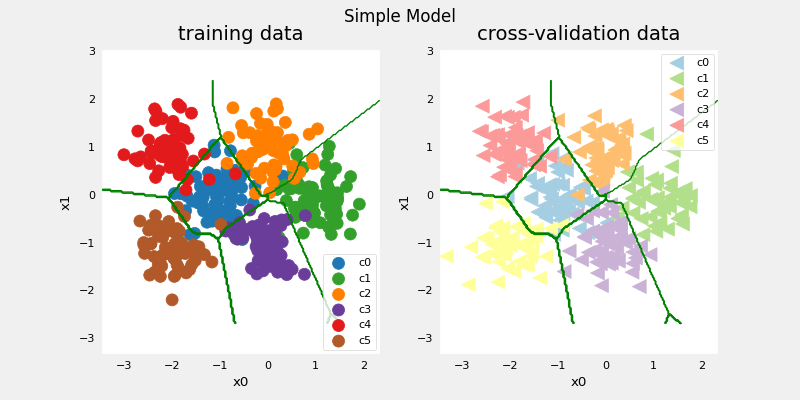

In [31]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

This simple models does pretty well. Let's calculate the classification error.

In [32]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 1ms/step
categorization error, training, simple model, 0.072, complex model: 0.013
categorization error, cv,       simple model, 0.069, complex model: 0.106


Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

<a name="6"></a>
## 6 - Regularization
As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.

<a name="ex05"></a>
### Exercise 5

Reconstruct your complex model, but this time include regularization.
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 40 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [33]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ### 
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"),
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"), 
        Dense(classes, activation = 'linear', name="L3")  
        ### START CODE HERE ### 
    ], name= "ComplexRegularized"
)
model_r.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### START CODE HERE ### 
)
model_r.fit(
    X_train,y_train,
    epochs=1000
)  

Epoch 1/1000
13/13 [==============================] - 1s 2ms/step - loss: 4.3986
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.6436
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.2765
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.0498
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9718
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9361
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9183
Epoch 8/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8842
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8066
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7610
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7505
Epoch 12/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7466
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 2ms/step - loss: 0.4839
Epoch 102/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4685
Epoch 103/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4676
Epoch 104/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4541
Epoch 105/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4990
Epoch 106/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4674
Epoch 107/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4596
Epoch 108/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4719
Epoch 109/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4547
Epoch 110/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4501
Epoch 111/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4519
Epoch 112/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4486
Epoch 113/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4028
Epoch 200/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3983
Epoch 201/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4238
Epoch 202/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3913
Epoch 203/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3954
Epoch 204/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4015
Epoch 205/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4514
Epoch 206/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4260
Epoch 207/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4076
Epoch 208/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4174
Epoch 209/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4381
Epoch 210/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4074
Epoch 211/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3856
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3960
Epoch 299/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3927
Epoch 300/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4289
Epoch 301/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3914
Epoch 302/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3896
Epoch 303/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3853
Epoch 304/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3717
Epoch 305/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3724
Epoch 306/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3840
Epoch 307/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3899
Epoch 308/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3886
Epoch 309/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3858
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3792
Epoch 397/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3903
Epoch 398/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3793
Epoch 399/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3758
Epoch 400/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3745
Epoch 401/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3541
Epoch 402/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3592
Epoch 403/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3561
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3535
Epoch 405/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3503
Epoch 406/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3550
Epoch 407/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3505
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3483
Epoch 495/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3467
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3620
Epoch 497/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3940
Epoch 498/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3497
Epoch 499/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3358
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3581
Epoch 501/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3492
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3589
Epoch 503/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3850
Epoch 504/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3741
Epoch 505/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3455
Epoch 592/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3410
Epoch 593/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3392
Epoch 594/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3351
Epoch 595/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4133
Epoch 596/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3908
Epoch 597/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3462
Epoch 598/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3390
Epoch 599/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3324
Epoch 600/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3512
Epoch 601/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3319
Epoch 602/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3503
Epoch 603/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3967
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3732
Epoch 691/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3461
Epoch 692/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3468
Epoch 693/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3374
Epoch 694/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3342
Epoch 695/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3290
Epoch 696/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3276
Epoch 697/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3253
Epoch 698/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3399
Epoch 699/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3355
Epoch 700/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3470
Epoch 701/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3560
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3672
Epoch 789/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3477
Epoch 790/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3456
Epoch 791/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3601
Epoch 792/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3657
Epoch 793/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3458
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3501
Epoch 795/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3510
Epoch 796/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3707
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3241
Epoch 798/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3594
Epoch 799/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3417
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3452
Epoch 887/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3246
Epoch 888/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3354
Epoch 889/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3302
Epoch 890/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3651
Epoch 891/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3267
Epoch 892/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3290
Epoch 893/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3423
Epoch 894/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3495
Epoch 895/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3951
Epoch 896/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3570
Epoch 897/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3134
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3291
Epoch 985/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3359
Epoch 986/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3365
Epoch 987/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3271
Epoch 988/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3152
Epoch 989/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3257
Epoch 990/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3329
Epoch 991/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3516
Epoch 992/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3358
Epoch 993/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3202
Epoch 994/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3251
Epoch 995/1000
13/1

In [34]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3144
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3228
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3375
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3340
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3186
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3206
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3550
Epoch 8/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3269
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3172
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3111
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3293
Epoch 12/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3480
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 2ms/step - loss: 0.3393
Epoch 102/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3253
Epoch 103/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3268
Epoch 104/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3167
Epoch 105/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3297
Epoch 106/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3041
Epoch 107/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3489
Epoch 108/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3831
Epoch 109/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3548
Epoch 110/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3295
Epoch 111/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3236
Epoch 112/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3145
Epoch 113/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3201
Epoch 200/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3164
Epoch 201/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3539
Epoch 202/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3122
Epoch 203/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3148
Epoch 204/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3229
Epoch 205/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3966
Epoch 206/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3508
Epoch 207/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3258
Epoch 208/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3426
Epoch 209/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3634
Epoch 210/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3281
Epoch 211/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3309
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3454
Epoch 299/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3352
Epoch 300/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3836
Epoch 301/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3362
Epoch 302/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3315
Epoch 303/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3353
Epoch 304/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3111
Epoch 305/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3131
Epoch 306/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3241
Epoch 307/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3406
Epoch 308/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3601
Epoch 309/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3401
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3358
Epoch 397/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3385
Epoch 398/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3328
Epoch 399/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3318
Epoch 400/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3393
Epoch 401/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3098
Epoch 402/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3089
Epoch 403/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3100
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3062
Epoch 405/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3015
Epoch 406/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3058
Epoch 407/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3155
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3080
Epoch 495/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3049
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3259
Epoch 497/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3547
Epoch 498/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3115
Epoch 499/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2979
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3226
Epoch 501/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3137
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3271
Epoch 503/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3570
Epoch 504/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3492
Epoch 505/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3170
Epoch 592/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3105
Epoch 593/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3073
Epoch 594/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2992
Epoch 595/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3852
Epoch 596/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3617
Epoch 597/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3148
Epoch 598/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3067
Epoch 599/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2988
Epoch 600/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3234
Epoch 601/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3017
Epoch 602/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3124
Epoch 603/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3707
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3467
Epoch 691/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3206
Epoch 692/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3188
Epoch 693/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3085
Epoch 694/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3043
Epoch 695/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3007
Epoch 696/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3007
Epoch 697/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2955
Epoch 698/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3130
Epoch 699/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3088
Epoch 700/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3185
Epoch 701/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3154
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3059
Epoch 789/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3164
Epoch 790/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3154
Epoch 791/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3434
Epoch 792/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3546
Epoch 793/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3221
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3295
Epoch 795/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3262
Epoch 796/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3423
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3017
Epoch 798/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3449
Epoch 799/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3133
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3217
Epoch 887/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3040
Epoch 888/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3135
Epoch 889/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3072
Epoch 890/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3445
Epoch 891/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3053
Epoch 892/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3129
Epoch 893/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3317
Epoch 894/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3392
Epoch 895/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3866
Epoch 896/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3381
Epoch 897/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2938
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3071
Epoch 985/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3159
Epoch 986/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3249
Epoch 987/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3185
Epoch 988/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2957
Epoch 989/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3073
Epoch 990/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3111
Epoch 991/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3245
Epoch 992/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3256
Epoch 993/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3106
Epoch 994/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3025
Epoch 995/1000
13/1

In [35]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "ComplexRegularized"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 120)               360       
                                                                 
 L2 (Dense)                  (None, 40)                4840      
                                                                 
 L3 (Dense)                  (None, 6)                 246       
                                                                 
Total params: 5446 (42.55 KB)
Trainable params: 5446 (42.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
ddd
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 1s 1ms/step


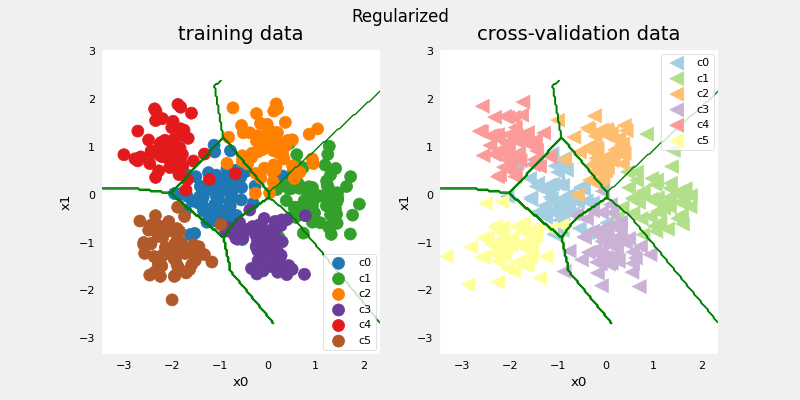

In [36]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

The results look very similar to the 'ideal' model. Let's check classification error.

In [37]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 2ms/step
categorization error, training, regularized: 0.075, simple model, 0.072, complex model: 0.013
categorization error, cv,       regularized: 0.072, simple model, 0.069, complex model: 0.106


The simple model is a bit better in the training set than the regularized model but it worse in the cross validation set.

<a name="7"></a>
## 7 - Iterate to find optimal regularization value
As you did in linear regression, you can try many regularization values. This code takes several minutes to run. If you have time, you can run it and check the results. If not, you have completed the graded parts of the assignment!

In [38]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 1s 2ms/step - loss: 1.1059
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4148
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3267
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2903
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2547
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2727
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2381
Epoch 8/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2231
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2295
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1951
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2117
Epoch 12/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1986
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 2ms/step - loss: 0.1614
Epoch 102/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1549
Epoch 103/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1788
Epoch 104/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1643
Epoch 105/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1497
Epoch 106/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1486
Epoch 107/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1521
Epoch 108/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1432
Epoch 109/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1428
Epoch 110/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1383
Epoch 111/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1416
Epoch 112/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1454
Epoch 113/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1104
Epoch 200/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1173
Epoch 201/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1000
Epoch 202/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0995
Epoch 203/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1019
Epoch 204/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0996
Epoch 205/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1010
Epoch 206/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1072
Epoch 207/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1460
Epoch 208/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1458
Epoch 209/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1366
Epoch 210/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1514
Epoch 211/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0809
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0717
Epoch 299/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0673
Epoch 300/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0829
Epoch 301/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0852
Epoch 302/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0766
Epoch 303/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0780
Epoch 304/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0632
Epoch 305/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0720
Epoch 306/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0680
Epoch 307/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0759
Epoch 308/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0606
Epoch 309/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0477
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0405
Epoch 397/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0406
Epoch 398/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0471
Epoch 399/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0444
Epoch 400/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0476
Epoch 401/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 402/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0849
Epoch 403/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0628
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0683
Epoch 405/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0865
Epoch 406/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1140
Epoch 407/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0378
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0382
Epoch 495/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0386
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0355
Epoch 497/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0294
Epoch 498/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0328
Epoch 499/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0309
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0300
Epoch 501/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0366
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0357
Epoch 503/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0296
Epoch 504/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0309
Epoch 505/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0692
Epoch 592/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0486
Epoch 593/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0524
Epoch 594/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0372
Epoch 595/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0816
Epoch 596/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0747
Epoch 597/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0829
Epoch 598/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0417
Epoch 599/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0507
Epoch 600/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0925
Epoch 601/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0731
Epoch 602/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0697
Epoch 603/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2049
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3319
Epoch 691/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1867
Epoch 692/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1788
Epoch 693/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1630
Epoch 694/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1901
Epoch 695/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1265
Epoch 696/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1286
Epoch 697/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0894
Epoch 698/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0663
Epoch 699/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0723
Epoch 700/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0546
Epoch 701/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0737
Epoch 788/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0719
Epoch 789/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0399
Epoch 790/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0368
Epoch 791/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0534
Epoch 792/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0450
Epoch 793/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0341
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 795/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0299
Epoch 796/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 798/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 799/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0342
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0345
Epoch 887/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0546
Epoch 888/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0827
Epoch 889/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0647
Epoch 890/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0721
Epoch 891/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1104
Epoch 892/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0946
Epoch 893/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0830
Epoch 894/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0550
Epoch 895/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0610
Epoch 896/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0452
Epoch 897/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0245
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0233
Epoch 985/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0255
Epoch 986/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 987/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0261
Epoch 988/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0230
Epoch 989/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0239
Epoch 990/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0250
Epoch 991/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 992/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0234
Epoch 993/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0220
Epoch 994/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0235
Epoch 995/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2417
Epoch 83/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2341
Epoch 84/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2369
Epoch 85/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2532
Epoch 86/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2232
Epoch 87/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2254
Epoch 88/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2315
Epoch 89/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2300
Epoch 90/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2264
Epoch 91/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2183
Epoch 92/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2179
Epoch 93/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2192
Epoch 94/1000
13/13 [=========

13/13 [==============================] - 0s 2ms/step - loss: 0.2245
Epoch 182/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2142
Epoch 183/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2062
Epoch 184/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2077
Epoch 185/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2084
Epoch 186/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2056
Epoch 187/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2021
Epoch 188/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2037
Epoch 189/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2005
Epoch 190/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2032
Epoch 191/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2157
Epoch 192/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2038
Epoch 193/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2002
Epoch 280/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2000
Epoch 281/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1956
Epoch 282/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1905
Epoch 283/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2019
Epoch 284/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1909
Epoch 285/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1824
Epoch 286/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1933
Epoch 287/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1920
Epoch 288/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2160
Epoch 289/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2030
Epoch 290/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2008
Epoch 291/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1825
Epoch 378/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1833
Epoch 379/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1873
Epoch 380/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1855
Epoch 381/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1848
Epoch 382/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1894
Epoch 383/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1960
Epoch 384/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1897
Epoch 385/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1843
Epoch 386/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1818
Epoch 387/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1827
Epoch 388/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1850
Epoch 389/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1973
Epoch 476/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1803
Epoch 477/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1938
Epoch 478/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1988
Epoch 479/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1791
Epoch 480/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1796
Epoch 481/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1764
Epoch 482/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1811
Epoch 483/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1823
Epoch 484/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1921
Epoch 485/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1838
Epoch 486/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1765
Epoch 487/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1742
Epoch 574/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1720
Epoch 575/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1690
Epoch 576/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1677
Epoch 577/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1804
Epoch 578/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1856
Epoch 579/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1704
Epoch 580/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1835
Epoch 581/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1717
Epoch 582/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1660
Epoch 583/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1703
Epoch 584/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1734
Epoch 585/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1610
Epoch 672/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1705
Epoch 673/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1700
Epoch 674/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1811
Epoch 675/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1739
Epoch 676/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1700
Epoch 677/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1647
Epoch 678/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1685
Epoch 679/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1776
Epoch 680/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1763
Epoch 681/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1860
Epoch 682/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1807
Epoch 683/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1582
Epoch 770/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1585
Epoch 771/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1703
Epoch 772/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1637
Epoch 773/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1688
Epoch 774/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1688
Epoch 775/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1711
Epoch 776/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1622
Epoch 777/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1720
Epoch 778/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1654
Epoch 779/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1676
Epoch 780/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1634
Epoch 781/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1550
Epoch 868/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1636
Epoch 869/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1585
Epoch 870/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1643
Epoch 871/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1579
Epoch 872/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1547
Epoch 873/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1635
Epoch 874/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1585
Epoch 875/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1659
Epoch 876/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1614
Epoch 877/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1571
Epoch 878/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1656
Epoch 879/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1629
Epoch 966/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1595
Epoch 967/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1723
Epoch 968/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1755
Epoch 969/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1621
Epoch 970/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1572
Epoch 971/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1589
Epoch 972/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1625
Epoch 973/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1604
Epoch 974/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1694
Epoch 975/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1551
Epoch 976/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1540
Epoch 977/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3606
Epoch 65/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3664
Epoch 66/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3439
Epoch 67/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3629
Epoch 68/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3568
Epoch 69/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3317
Epoch 70/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3240
Epoch 71/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3239
Epoch 72/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3011
Epoch 73/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3085
Epoch 74/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3100
Epoch 75/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3267
Epoch 76/1000
13/13 [=========

13/13 [==============================] - 0s 2ms/step - loss: 0.2798
Epoch 164/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2945
Epoch 165/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2994
Epoch 166/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2946
Epoch 167/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2878
Epoch 168/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2798
Epoch 169/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2903
Epoch 170/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2876
Epoch 171/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2728
Epoch 172/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2636
Epoch 173/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2872
Epoch 174/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2981
Epoch 175/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2884
Epoch 262/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2707
Epoch 263/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2739
Epoch 264/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2550
Epoch 265/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2733
Epoch 266/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2668
Epoch 267/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2733
Epoch 268/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2629
Epoch 269/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2549
Epoch 270/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2619
Epoch 271/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2610
Epoch 272/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2639
Epoch 273/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2488
Epoch 360/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2632
Epoch 361/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2661
Epoch 362/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3126
Epoch 363/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3013
Epoch 364/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2804
Epoch 365/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2636
Epoch 366/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2530
Epoch 367/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2797
Epoch 368/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2857
Epoch 369/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2732
Epoch 370/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2521
Epoch 371/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2335
Epoch 458/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2532
Epoch 459/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2454
Epoch 460/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2425
Epoch 461/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2651
Epoch 462/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2462
Epoch 463/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2360
Epoch 464/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2422
Epoch 465/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2552
Epoch 466/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2612
Epoch 467/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2514
Epoch 468/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2540
Epoch 469/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2440
Epoch 556/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2318
Epoch 557/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2348
Epoch 558/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2449
Epoch 559/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2697
Epoch 560/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2657
Epoch 561/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2384
Epoch 562/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2585
Epoch 563/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2312
Epoch 564/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2358
Epoch 565/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2350
Epoch 566/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2418
Epoch 567/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2240
Epoch 654/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2402
Epoch 655/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2292
Epoch 656/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2304
Epoch 657/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2332
Epoch 658/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2352
Epoch 659/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2274
Epoch 660/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2412
Epoch 661/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2324
Epoch 662/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2383
Epoch 663/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2375
Epoch 664/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2664
Epoch 665/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2302
Epoch 752/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2392
Epoch 753/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2219
Epoch 754/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2345
Epoch 755/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2306
Epoch 756/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2303
Epoch 757/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2362
Epoch 758/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2264
Epoch 759/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2273
Epoch 760/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2377
Epoch 761/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2410
Epoch 762/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2339
Epoch 763/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2253
Epoch 850/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2242
Epoch 851/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2353
Epoch 852/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2497
Epoch 853/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2313
Epoch 854/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2327
Epoch 855/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2380
Epoch 856/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2247
Epoch 857/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2316
Epoch 858/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2266
Epoch 859/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2345
Epoch 860/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2262
Epoch 861/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2322
Epoch 948/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2302
Epoch 949/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2233
Epoch 950/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2167
Epoch 951/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2243
Epoch 952/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2395
Epoch 953/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2253
Epoch 954/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2357
Epoch 955/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2227
Epoch 956/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2301
Epoch 957/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2351
Epoch 958/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2475
Epoch 959/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4546
Epoch 47/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4339
Epoch 48/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4792
Epoch 49/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4746
Epoch 50/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4417
Epoch 51/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4527
Epoch 52/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4415
Epoch 53/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4518
Epoch 54/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4320
Epoch 55/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4622
Epoch 56/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4234
Epoch 57/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4403
Epoch 58/1000
13/13 [=========

13/13 [==============================] - 0s 2ms/step - loss: 0.3583
Epoch 146/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3535
Epoch 147/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3747
Epoch 148/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3601
Epoch 149/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3545
Epoch 150/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3533
Epoch 151/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3568
Epoch 152/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3476
Epoch 153/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3716
Epoch 154/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3537
Epoch 155/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3561
Epoch 156/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3605
Epoch 157/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3324
Epoch 244/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3447
Epoch 245/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3410
Epoch 246/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3373
Epoch 247/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3262
Epoch 248/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3366
Epoch 249/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3478
Epoch 250/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3381
Epoch 251/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3671
Epoch 252/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3442
Epoch 253/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3375
Epoch 254/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3553
Epoch 255/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3233
Epoch 342/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3352
Epoch 343/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3233
Epoch 344/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3176
Epoch 345/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3173
Epoch 346/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3237
Epoch 347/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3299
Epoch 348/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3394
Epoch 349/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3073
Epoch 350/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3340
Epoch 351/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3123
Epoch 352/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3364
Epoch 353/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3074
Epoch 440/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3027
Epoch 441/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3092
Epoch 442/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3166
Epoch 443/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3132
Epoch 444/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3037
Epoch 445/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3147
Epoch 446/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3080
Epoch 447/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3356
Epoch 448/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3233
Epoch 449/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3022
Epoch 450/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3029
Epoch 451/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3575
Epoch 538/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3175
Epoch 539/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2897
Epoch 540/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3090
Epoch 541/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3253
Epoch 542/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3311
Epoch 543/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3177
Epoch 544/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3108
Epoch 545/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2974
Epoch 546/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3104
Epoch 547/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3222
Epoch 548/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3035
Epoch 549/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3241
Epoch 636/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3116
Epoch 637/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3061
Epoch 638/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2978
Epoch 639/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2938
Epoch 640/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2869
Epoch 641/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2867
Epoch 642/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3052
Epoch 643/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3114
Epoch 644/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2861
Epoch 645/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3093
Epoch 646/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3184
Epoch 647/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2952
Epoch 734/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3078
Epoch 735/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3076
Epoch 736/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3120
Epoch 737/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3173
Epoch 738/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2872
Epoch 739/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 740/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2998
Epoch 741/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3149
Epoch 742/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3495
Epoch 743/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2970
Epoch 744/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2909
Epoch 745/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3038
Epoch 832/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3136
Epoch 833/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3167
Epoch 834/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2856
Epoch 835/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2907
Epoch 836/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2802
Epoch 837/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2908
Epoch 838/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2939
Epoch 839/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2976
Epoch 840/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3186
Epoch 841/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2864
Epoch 842/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3042
Epoch 843/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2769
Epoch 930/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3178
Epoch 931/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3176
Epoch 932/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2941
Epoch 933/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3001
Epoch 934/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3247
Epoch 935/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2914
Epoch 936/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2896
Epoch 937/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2806
Epoch 938/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2935
Epoch 939/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2850
Epoch 940/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2805
Epoch 941/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.6128
Epoch 29/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5999
Epoch 30/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6269
Epoch 31/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6242
Epoch 32/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6332
Epoch 33/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6192
Epoch 34/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6580
Epoch 35/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6360
Epoch 36/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6090
Epoch 37/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5823
Epoch 38/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5649
Epoch 39/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5636
Epoch 40/1000
13/13 [=========

13/13 [==============================] - 0s 2ms/step - loss: 0.4431
Epoch 128/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4295
Epoch 129/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4400
Epoch 130/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4332
Epoch 131/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4511
Epoch 132/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4291
Epoch 133/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.4224
Epoch 134/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4448
Epoch 135/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4399
Epoch 136/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4438
Epoch 137/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4248
Epoch 138/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4446
Epoch 139/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4331
Epoch 226/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4214
Epoch 227/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4383
Epoch 228/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3923
Epoch 229/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4047
Epoch 230/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4120
Epoch 231/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4017
Epoch 232/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4143
Epoch 233/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3927
Epoch 234/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3898
Epoch 235/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3896
Epoch 236/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3980
Epoch 237/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4036
Epoch 324/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4116
Epoch 325/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3987
Epoch 326/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3856
Epoch 327/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3803
Epoch 328/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3955
Epoch 329/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3794
Epoch 330/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3677
Epoch 331/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3734
Epoch 332/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3745
Epoch 333/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4125
Epoch 334/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3937
Epoch 335/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3838
Epoch 422/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3936
Epoch 423/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3747
Epoch 424/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3759
Epoch 425/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3654
Epoch 426/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3623
Epoch 427/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3646
Epoch 428/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3720
Epoch 429/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3716
Epoch 430/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3688
Epoch 431/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3553
Epoch 432/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3630
Epoch 433/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3664
Epoch 520/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3674
Epoch 521/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3491
Epoch 522/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3644
Epoch 523/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3769
Epoch 524/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3417
Epoch 525/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3500
Epoch 526/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3546
Epoch 527/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3419
Epoch 528/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3471
Epoch 529/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3773
Epoch 530/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3666
Epoch 531/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3300
Epoch 618/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3663
Epoch 619/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3885
Epoch 620/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3847
Epoch 621/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3495
Epoch 622/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3517
Epoch 623/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3429
Epoch 624/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3324
Epoch 625/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3312
Epoch 626/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3431
Epoch 627/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3537
Epoch 628/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3658
Epoch 629/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3288
Epoch 716/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3389
Epoch 717/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3549
Epoch 718/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3704
Epoch 719/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3640
Epoch 720/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3726
Epoch 721/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3734
Epoch 722/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3564
Epoch 723/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3703
Epoch 724/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3574
Epoch 725/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3650
Epoch 726/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3575
Epoch 727/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3317
Epoch 814/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3351
Epoch 815/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3402
Epoch 816/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3406
Epoch 817/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3561
Epoch 818/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3511
Epoch 819/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3247
Epoch 820/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3626
Epoch 821/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3897
Epoch 822/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3484
Epoch 823/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3405
Epoch 824/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3498
Epoch 825/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3197
Epoch 912/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3279
Epoch 913/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3248
Epoch 914/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3486
Epoch 915/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3527
Epoch 916/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3590
Epoch 917/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3415
Epoch 918/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3344
Epoch 919/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3492
Epoch 920/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3719
Epoch 921/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3371
Epoch 922/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3448
Epoch 923/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 1.1004
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.0739
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.0223
Epoch 12/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9940
Epoch 13/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9858
Epoch 14/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9784
Epoch 15/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9334
Epoch 16/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9210
Epoch 17/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9274
Epoch 18/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9205
Epoch 19/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8937
Epoch 20/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8757
Epoch 21/1000
13/13 [=========

Epoch 109/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5817
Epoch 110/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5712
Epoch 111/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5712
Epoch 112/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5640
Epoch 113/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5594
Epoch 114/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5573
Epoch 115/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5601
Epoch 116/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5620
Epoch 117/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5925
Epoch 118/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5893
Epoch 119/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5914
Epoch 120/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5769
Epoc

13/13 [==============================] - 0s 2ms/step - loss: 0.5175
Epoch 208/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5236
Epoch 209/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5306
Epoch 210/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5047
Epoch 211/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5111
Epoch 212/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4930
Epoch 213/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4889
Epoch 214/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4888
Epoch 215/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4951
Epoch 216/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5061
Epoch 217/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4978
Epoch 218/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5014
Epoch 219/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4613
Epoch 306/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4794
Epoch 307/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4656
Epoch 308/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4576
Epoch 309/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4674
Epoch 310/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4554
Epoch 311/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4509
Epoch 312/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4525
Epoch 313/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4584
Epoch 314/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4582
Epoch 315/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4529
Epoch 316/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4494
Epoch 317/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4435
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4453
Epoch 405/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4302
Epoch 406/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4327
Epoch 407/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4457
Epoch 408/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4508
Epoch 409/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4322
Epoch 410/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4481
Epoch 411/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4678
Epoch 412/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4350
Epoch 413/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4430
Epoch 414/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4510
Epoch 415/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4146
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4210
Epoch 503/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4538
Epoch 504/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4576
Epoch 505/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4471
Epoch 506/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4574
Epoch 507/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4334
Epoch 508/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4137
Epoch 509/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4217
Epoch 510/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4129
Epoch 511/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4188
Epoch 512/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4255
Epoch 513/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3998
Epoch 600/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4067
Epoch 601/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3983
Epoch 602/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4067
Epoch 603/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3988
Epoch 604/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4001
Epoch 605/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4056
Epoch 606/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4308
Epoch 607/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4274
Epoch 608/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4263
Epoch 609/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4113
Epoch 610/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4274
Epoch 611/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4021
Epoch 698/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4092
Epoch 699/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3982
Epoch 700/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3984
Epoch 701/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4069
Epoch 702/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3999
Epoch 703/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3819
Epoch 704/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4104
Epoch 705/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4052
Epoch 706/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4071
Epoch 707/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4201
Epoch 708/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4012
Epoch 709/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4390
Epoch 796/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4405
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3789
Epoch 798/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4023
Epoch 799/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3976
Epoch 800/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3951
Epoch 801/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3880
Epoch 802/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3878
Epoch 803/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3871
Epoch 804/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4029
Epoch 805/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3997
Epoch 806/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4158
Epoch 807/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3902
Epoch 894/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3953
Epoch 895/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4110
Epoch 896/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3853
Epoch 897/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3922
Epoch 898/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4108
Epoch 899/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4164
Epoch 900/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3938
Epoch 901/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4226
Epoch 902/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4101
Epoch 903/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4059
Epoch 904/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3763
Epoch 905/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3903
Epoch 992/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3710
Epoch 993/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3754
Epoch 994/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3845
Epoch 995/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3839
Epoch 996/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3798
Epoch 997/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4069
Epoch 998/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3738
Epoch 999/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3846
Epoch 1000/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4016
Finished lambda = 0.2
Epoch 1/1000
13/13 [==============================] - 1s 2ms/step - loss: 10.0980
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 2.3260

13/13 [==============================] - 0s 2ms/step - loss: 0.6978
Epoch 91/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6965
Epoch 92/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6862
Epoch 93/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6853
Epoch 94/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6753
Epoch 95/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6811
Epoch 96/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6696
Epoch 97/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6686
Epoch 98/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6809
Epoch 99/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7017
Epoch 100/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7089
Epoch 101/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7006
Epoch 102/1000
13/13 [======

Epoch 189/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5795
Epoch 190/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5687
Epoch 191/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5833
Epoch 192/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5841
Epoch 193/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5708
Epoch 194/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5659
Epoch 195/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5644
Epoch 196/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5617
Epoch 197/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5772
Epoch 198/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5633
Epoch 199/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5703
Epoch 200/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5672
Epoc

13/13 [==============================] - 0s 2ms/step - loss: 0.5645
Epoch 288/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5563
Epoch 289/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5292
Epoch 290/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5308
Epoch 291/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5382
Epoch 292/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5176
Epoch 293/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5237
Epoch 294/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5261
Epoch 295/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5548
Epoch 296/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5268
Epoch 297/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5175
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5231
Epoch 299/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4977
Epoch 386/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4803
Epoch 387/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4971
Epoch 388/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5012
Epoch 389/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4926
Epoch 390/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4792
Epoch 391/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4855
Epoch 392/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4889
Epoch 393/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4869
Epoch 394/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4892
Epoch 395/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5171
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5357
Epoch 397/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.5162
Epoch 484/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4736
Epoch 485/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5021
Epoch 486/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4770
Epoch 487/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4685
Epoch 488/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4601
Epoch 489/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4507
Epoch 490/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4653
Epoch 491/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4718
Epoch 492/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4911
Epoch 493/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4725
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4529
Epoch 495/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4868
Epoch 582/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4716
Epoch 583/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4676
Epoch 584/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4613
Epoch 585/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4909
Epoch 586/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4876
Epoch 587/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4554
Epoch 588/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4409
Epoch 589/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4311
Epoch 590/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4381
Epoch 591/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4462
Epoch 592/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4414
Epoch 593/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4426
Epoch 680/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4326
Epoch 681/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4735
Epoch 682/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4723
Epoch 683/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4317
Epoch 684/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4414
Epoch 685/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4552
Epoch 686/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4478
Epoch 687/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4282
Epoch 688/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4216
Epoch 689/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4778
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4622
Epoch 691/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4457
Epoch 778/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4578
Epoch 779/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4348
Epoch 780/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4339
Epoch 781/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4527
Epoch 782/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4164
Epoch 783/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4294
Epoch 784/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4300
Epoch 785/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4118
Epoch 786/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4176
Epoch 787/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4248
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4149
Epoch 789/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4225
Epoch 876/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4075
Epoch 877/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4149
Epoch 878/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4192
Epoch 879/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4148
Epoch 880/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4164
Epoch 881/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4336
Epoch 882/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4417
Epoch 883/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4656
Epoch 884/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4596
Epoch 885/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4453
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4082
Epoch 887/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4112
Epoch 974/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4172
Epoch 975/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4106
Epoch 976/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4051
Epoch 977/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4105
Epoch 978/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4009
Epoch 979/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4088
Epoch 980/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4246
Epoch 981/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4175
Epoch 982/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4174
Epoch 983/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4011
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4181
Epoch 985/1000
13/1

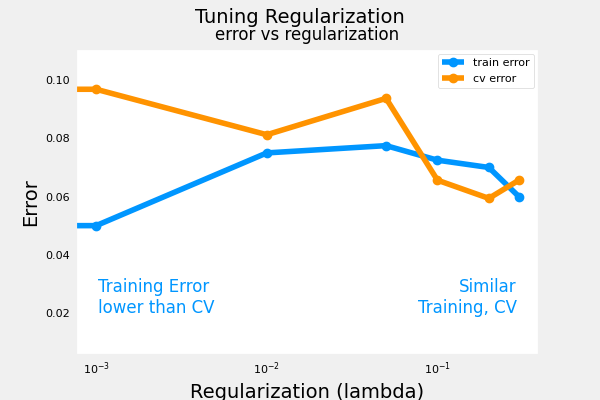

In [39]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

<a name="7.1"></a>
### 7.1 Test
Let's try our optimized models on the test set and compare them to 'ideal' performance. 

3/3 [==============================] - 0s 2ms/step


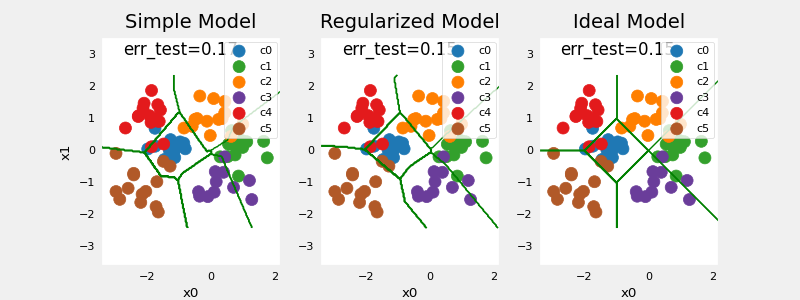

In [40]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.

## Congratulations! 
You have become familiar with important tools to apply when evaluating your machine learning models. Namely:  
* splitting data into trained and untrained sets allows you to differentiate between underfitting and overfitting
* creating three data sets, Training, Cross-Validation and Test allows you to
    * train your parameters $W,B$ with the training set
    * tune model parameters such as complexity, regularization and number of examples with the cross-validation set
    * evaluate your 'real world' performance using the test set.
* comparing training vs cross-validation performance provides insight into a model's propensity towards overfitting (high variance) or underfitting (high bias)